# Третья лабораторная работа

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, StandardScaler
import matplotlib.pyplot as plt
from math import sqrt
import seaborn as sns

In [2]:

data = pd.read_csv('../data/mumbai_houses_task.csv')

In [3]:
data.head(10)

,price,area,latitude,longitude,Bedrooms,Bathrooms,Balcony,Status,neworold,parking,Furnished_status,Lift,type_of_building
0,22400000.0,629.0,19.032800,72.896357,2.0,2.0,0.0,Under Construction,New Property,0.0,NaN,0.0,Flat
1,35000000.0,974.0,19.032800,72.896357,3.0,2.0,0.0,Under Construction,New Property,0.0,NaN,0.0,Flat
2,31700000.0,968.0,19.085600,72.909277,3.0,3.0,0.0,Under Construction,New Property,0.0,NaN,0.0,Flat
3,18700000.0,629.0,19.155756,72.846862,2.0,2.0,2.0,Ready to Move,New Property,2.0,NaN,2.0,Flat
4,13500000.0,1090.0,19.177555,72.849887,2.0,2.0,0.0,NaN,New Property,0.0,Unfurnished,0.0,Flat
5,13000000.0,630.0,19.148058,72.937725,2.0,2.0,0.0,NaN,New Property,0.0,Unfurnished,0.0,Flat
6,20700000.0,1188.0,19.154919,72.843566,2.0,2.0,2.0,NaN,New Property,2.0,Semi-Furnished,2.0,Flat
7,22900000.0,968.0,19.147269,72.848351,3.0,3.0,0.0,NaN,New Property,0.0,Unfurnished,0.0,Flat
8,17000000.0,820.0,19.015128,72.858064,2.0,2.0,0.0,NaN,New Property,0.0,Unfurnished,0.0,Flat
9,81000000.0,3260.0,19.001640,72.826532,3.0,3.0,3.0,Ready to Move,Resale,3.0,NaN,3.0,Flat


Опишем поля датасета:

- price - цена
- area - площадь дома/квартиры

- latitude/longitude - широта/долгота (в градусах)
- Bedrooms - кол-во спален
- Balcony - кол-во балконов
- Status - статус дома/квартиры (строящийся/готовый к заселению)
- neworold - новое или старое (новое/перепродажа)
- parking - кол-во парковочных мест на дом/квартиру
- Furnished_status - статус "омеблериванности" (Полу-меблированный, немеблированный, меблированный)
- Lift - кол-во лифтов в помещении
- type_of_building - тип здания: дом/квартира


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6255 entries, 0 to 6254
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price             6255 non-null   float64
 1   area              6255 non-null   float64
 2   latitude          6255 non-null   float64
 3   longitude         6255 non-null   float64
 4   Bedrooms          6255 non-null   float64
 5   Bathrooms         6255 non-null   float64
 6   Balcony           6255 non-null   float64
 7   Status            5774 non-null   object 
 8   neworold          6255 non-null   object 
 9   parking           6255 non-null   float64
 10  Furnished_status  3600 non-null   object 
 11  Lift              6255 non-null   float64
 12  type_of_building  6255 non-null   object 
dtypes: float64(9), object(4)
memory usage: 635.4+ KB


# Предобработка данных

## *Меняем имена столбцов*

In [5]:
data.columns

Index(['price', 'area', 'latitude', 'longitude', 'Bedrooms', 'Bathrooms',
       'Balcony', 'Status', 'neworold', 'parking', 'Furnished_status', 'Lift',
       'type_of_building'],
      dtype='object')

In [6]:
data = data.rename(
    columns = {x: '_'.join(x.lower().split()) for x in data.columns}
)
data.columns

Index(['price', 'area', 'latitude', 'longitude', 'bedrooms', 'bathrooms',
       'balcony', 'status', 'neworold', 'parking', 'furnished_status', 'lift',
       'type_of_building'],
      dtype='object')

## *Заполняем пропущенные значения*

In [7]:
data.isna().sum().sort_values(ascending=False)

furnished_status    2655
status               481
price                  0
area                   0
latitude               0
longitude              0
bedrooms               0
bathrooms              0
balcony                0
neworold               0
parking                0
lift                   0
type_of_building       0
dtype: int64

Можно предположить, если при написании объявления не упомянули каку-либо мебель, значит её и не имели в виду, то есть её не будет. Потому большое кол-во пропущенных значений поля furnished_status имеет смысл заполнить как "Unfurnished"

In [8]:
data["furnished_status"] = data["furnished_status"].fillna("Unfurnished")
data["furnished_status"].isna().sum()

0

Аналогично и с полем статуса дома/квартиры: если бы он не был готов к заселению, в объявлении 100% это указали бы, следовательно, имеет смысл заполнить все пропуски домами, готовыми к заселению: "Ready to Move"

In [9]:
data["status"] = data["status"].fillna("Ready to Move")
data.isna().sum()

price               0
area                0
latitude            0
longitude           0
bedrooms            0
bathrooms           0
balcony             0
status              0
neworold            0
parking             0
furnished_status    0
lift                0
type_of_building    0
dtype: int64

### Проверяем наличие/избавляемся дубликатов

In [10]:
data.duplicated().sum()

18

In [11]:
data = data.drop_duplicates().reset_index(drop= True)

In [12]:
data.duplicated().sum()

0

## Корректируем тип данных столбцов

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6237 entries, 0 to 6236
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price             6237 non-null   float64
 1   area              6237 non-null   float64
 2   latitude          6237 non-null   float64
 3   longitude         6237 non-null   float64
 4   bedrooms          6237 non-null   float64
 5   bathrooms         6237 non-null   float64
 6   balcony           6237 non-null   float64
 7   status            6237 non-null   object 
 8   neworold          6237 non-null   object 
 9   parking           6237 non-null   float64
 10  furnished_status  6237 non-null   object 
 11  lift              6237 non-null   float64
 12  type_of_building  6237 non-null   object 
dtypes: float64(9), object(4)
memory usage: 633.6+ KB


In [14]:
data.head(10)

,price,area,latitude,longitude,bedrooms,bathrooms,balcony,status,neworold,parking,furnished_status,lift,type_of_building
0,22400000.0,629.0,19.032800,72.896357,2.0,2.0,0.0,Under Construction,New Property,0.0,Unfurnished,0.0,Flat
1,35000000.0,974.0,19.032800,72.896357,3.0,2.0,0.0,Under Construction,New Property,0.0,Unfurnished,0.0,Flat
2,31700000.0,968.0,19.085600,72.909277,3.0,3.0,0.0,Under Construction,New Property,0.0,Unfurnished,0.0,Flat
3,18700000.0,629.0,19.155756,72.846862,2.0,2.0,2.0,Ready to Move,New Property,2.0,Unfurnished,2.0,Flat
4,13500000.0,1090.0,19.177555,72.849887,2.0,2.0,0.0,Ready to Move,New Property,0.0,Unfurnished,0.0,Flat
5,13000000.0,630.0,19.148058,72.937725,2.0,2.0,0.0,Ready to Move,New Property,0.0,Unfurnished,0.0,Flat
6,20700000.0,1188.0,19.154919,72.843566,2.0,2.0,2.0,Ready to Move,New Property,2.0,Semi-Furnished,2.0,Flat
7,22900000.0,968.0,19.147269,72.848351,3.0,3.0,0.0,Ready to Move,New Property,0.0,Unfurnished,0.0,Flat
8,17000000.0,820.0,19.015128,72.858064,2.0,2.0,0.0,Ready to Move,New Property,0.0,Unfurnished,0.0,Flat
9,81000000.0,3260.0,19.001640,72.826532,3.0,3.0,3.0,Ready to Move,Resale,3.0,Unfurnished,3.0,Flat


In [15]:
data["status"].unique()

array(['Under Construction', 'Ready to Move'], dtype=object)

Поскольку neworold, status принимают два разных значения, потому заменим на тип bool. 
Количественные столбцы имеет смысл заменить на int: bedrooms, bathrooms, balcony, parking, lift.

Так как нам дальше в задачи линейной регрессии нужны будут только признаки с числовым типом данных, заменим значения поля furnished_status: Furnished, Unfurnished, Semi-furnished на 1,0 и 0.5 соответственно. 

In [16]:
float_to_int = {"bedrooms", "bathrooms", "balcony", "parking", "lift"}
for field in float_to_int: 
    data[field] = data[field].astype(int)

In [17]:
dict_neworold = {"New Property": True, "Resale": False}
data["neworold"] = data["neworold"].map(dict_neworold)

dict_status = {"Ready to Move": True, "Under Construction": False}
data["status"] = data["status"].map(dict_status)

dict_furnished = {"Semi-Furnished": 0.5, "Furnished": 1, "Unfurnished": 0} # так ваще можно делать?
data["furnished_status"] = data["furnished_status"].map(dict_furnished)


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6237 entries, 0 to 6236
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price             6237 non-null   float64
 1   area              6237 non-null   float64
 2   latitude          6237 non-null   float64
 3   longitude         6237 non-null   float64
 4   bedrooms          6237 non-null   int64  
 5   bathrooms         6237 non-null   int64  
 6   balcony           6237 non-null   int64  
 7   status            6237 non-null   bool   
 8   neworold          6237 non-null   bool   
 9   parking           6237 non-null   int64  
 10  furnished_status  6237 non-null   float64
 11  lift              6237 non-null   int64  
 12  type_of_building  6237 non-null   object 
dtypes: bool(2), float64(5), int64(5), object(1)
memory usage: 548.3+ KB


# EDA

Основные параметры, влиящие на цену:
- area
- bedrooms
- bathrooms
- balcony
- parking
- lift

In [19]:
columns = ["price","area", "bedrooms", "bathrooms", "balcony","parking", "lift"]

data.describe()[columns]

,price,area,bedrooms,bathrooms,balcony,parking,lift
count,6.237000e+03,6237.000000,6237.000000,6237.000000,6237.000000,6237.000000,6237.000000
mean,2.686215e+07,1185.597723,2.452301,2.425525,0.822350,0.822350,0.822350
std,2.792125e+07,637.515522,0.750140,0.763236,1.291977,1.291977,1.291977
min,1.500000e+06,503.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,1.300000e+07,846.000000,2.000000,2.000000,0.000000,0.000000,0.000000
50%,1.900000e+07,1000.000000,2.000000,2.000000,0.000000,0.000000,0.000000
75%,3.000000e+07,1300.000000,3.000000,3.000000,1.000000,1.000000,1.000000
max,3.600000e+08,8000.000000,10.000000,10.000000,8.000000,8.000000,8.000000


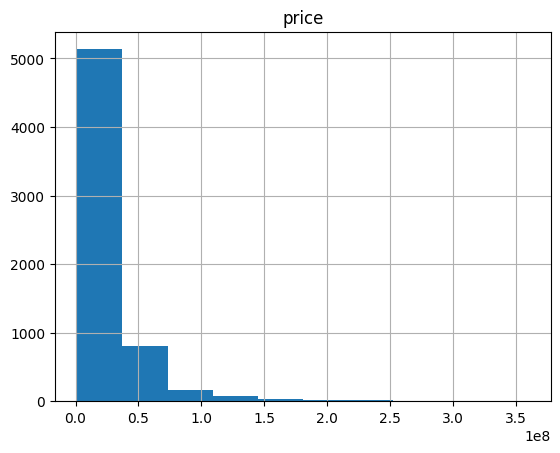

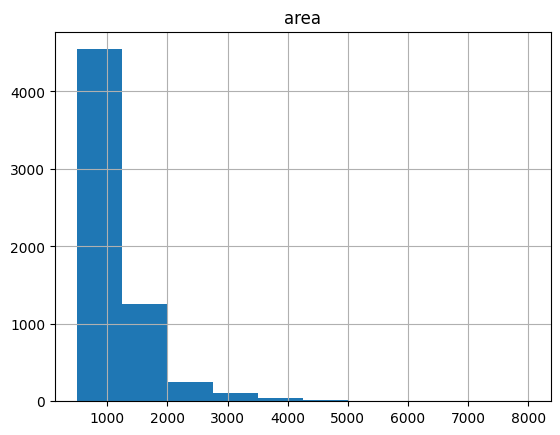

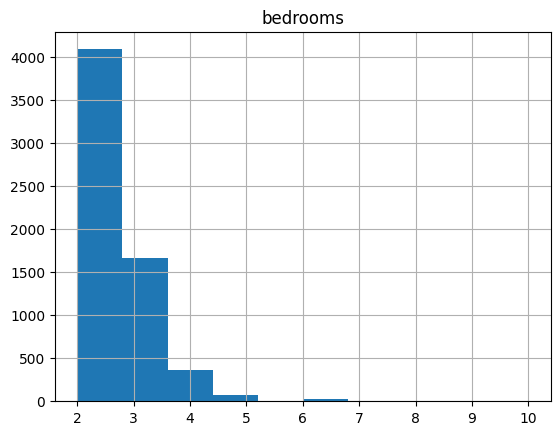

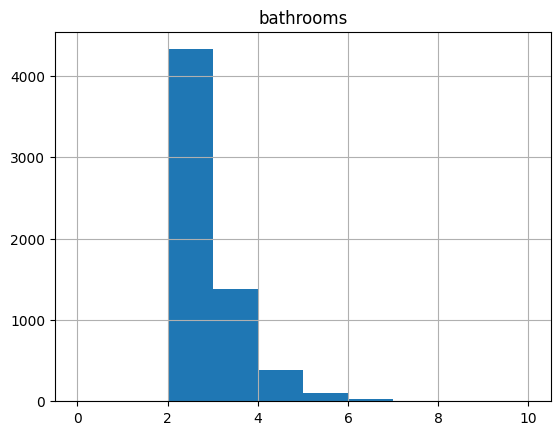

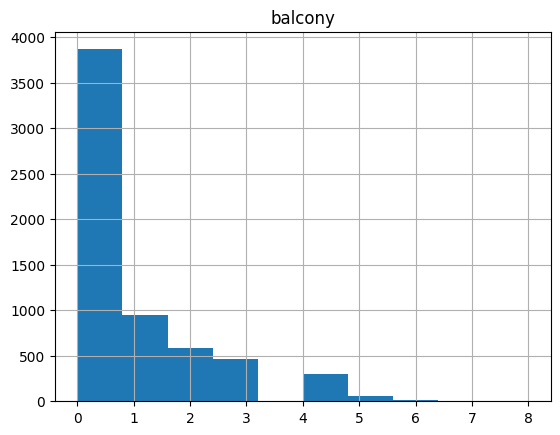

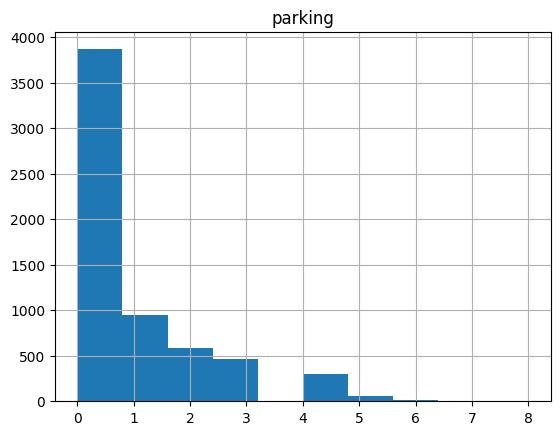

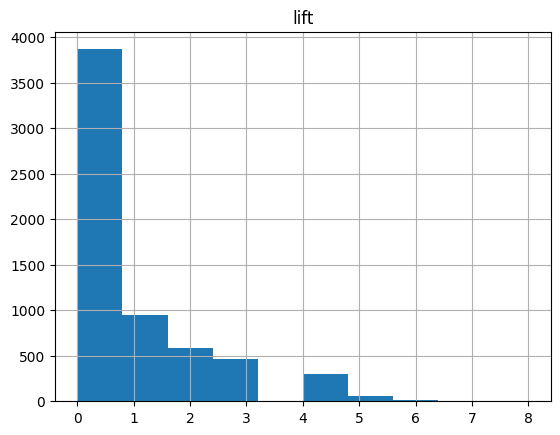

In [20]:
for column in columns: data.hist(column)

Нужно убрать аномальные значения у price, area, чтобы данные по графику было легче прочитать. У полей целочисленного типа уникальных значений не так много, следовательно, удалив выбросы, мы ещё уменьшим кол-во уникальных значений, потому это не целесообразно.

## Изучение и обработка выбросов

In [21]:
outliers = data[["price","area"]]
outliers

,price,area
0,22400000.0,629.0
1,35000000.0,974.0
2,31700000.0,968.0
3,18700000.0,629.0
4,13500000.0,1090.0
...,...,...
6232,19500000.0,810.0
6233,22000000.0,1400.0
6234,20000000.0,750.0
6235,11000000.0,700.0


In [22]:
# Определить нижние пределы для выбросов
Q1 = outliers.quantile(0.25)
Q1

price    13000000.0
area          846.0
Name: 0.25, dtype: float64

In [23]:
# Определить верхние пределы выбросов
Q3 = outliers.quantile(0.75)
Q3

price    30000000.0
area         1300.0
Name: 0.75, dtype: float64

In [24]:
# IQR-оценки
IQR = Q3-Q1
# Отфильтрованные данные, из которых удалены выбросы
data_filtered = outliers[~((outliers < (Q1 - 1.5 * IQR)) |(outliers > (Q3 + 1.5 * IQR))).any(axis=1)]
data_filtered

,price,area
0,22400000.0,629.0
1,35000000.0,974.0
2,31700000.0,968.0
3,18700000.0,629.0
4,13500000.0,1090.0
...,...,...
6232,19500000.0,810.0
6233,22000000.0,1400.0
6234,20000000.0,750.0
6235,11000000.0,700.0


In [25]:
# Копирование индексов
index_list = list(data_filtered.index.values)
# index_list

In [26]:
# Хранить данные без выбросов в отдельном DataFrame.
data_filtered = data[data.index.isin(index_list)]
data_filtered.head()

,price,area,latitude,longitude,bedrooms,bathrooms,balcony,status,neworold,parking,furnished_status,lift,type_of_building
0,22400000.0,629.0,19.032800,72.896357,2,2,0,False,True,0,0.0,0,Flat
1,35000000.0,974.0,19.032800,72.896357,3,2,0,False,True,0,0.0,0,Flat
2,31700000.0,968.0,19.085600,72.909277,3,3,0,False,True,0,0.0,0,Flat
3,18700000.0,629.0,19.155756,72.846862,2,2,2,True,True,2,0.0,2,Flat
4,13500000.0,1090.0,19.177555,72.849887,2,2,0,True,True,0,0.0,0,Flat


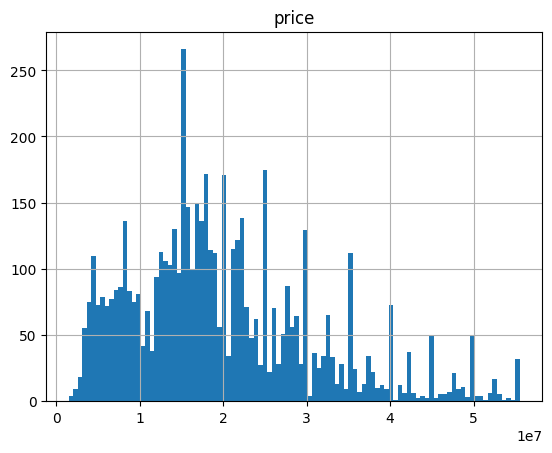

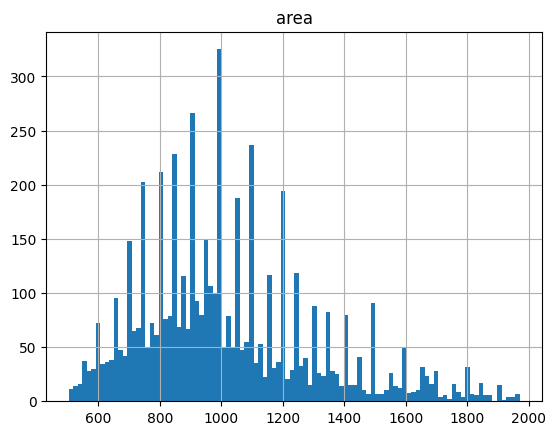

In [27]:
# создать гистограмму с отфильтрованным выбросом
filtered_outliers = data_filtered[['price',"area"]]

for col in filtered_outliers:
    data_filtered.hist(col, bins=100)

**Заключение**:
- у двух полей удалили аномально большие значения, которых меньшинство; таким образом графики стали симметричнее

### Средняя цена за каждый тип жилья

In [28]:
# Создание переменной с типом и средней ценой
avg_price = data_filtered.pivot_table(index='type_of_building', values='price', aggfunc='mean')
avg_price

,price
type_of_building,
Flat,1.990770e+07
Individual House,1.950357e+07


Мы видим, что средние цены у квартиры и отдельного дома +\- одинаковые.

# Ценовые факторы

Основные параметры, влиящие на цену:
- area
- bedrooms
- bathrooms
- balcony
- parking
- lift

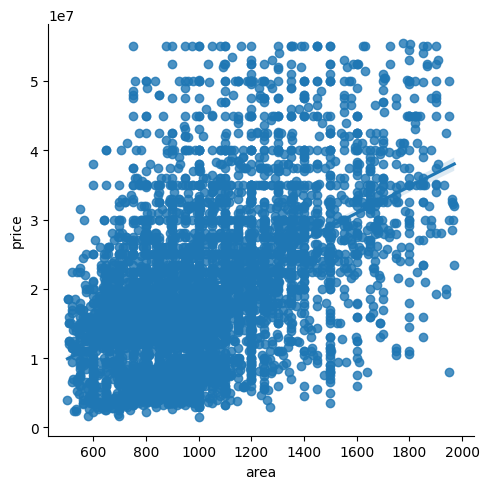

In [29]:
import seaborn as sns
sns.lmplot(x="area", y="price", data= data_filtered)

In [30]:
area = data[['area', 'price']]
corr_area = area.corr()
corr_area

,area,price
area,1.000000,0.712463
price,0.712463,1.000000


In [31]:
for field in ['bathrooms', 'bedrooms', 'balcony', 'parking', 'lift', 'furnished_status']:
    current = data[[field, 'price']]
    print(current.corr())

           bathrooms    price
bathrooms    1.00000  0.63937
price        0.63937  1.00000
          bedrooms     price
bedrooms  1.000000  0.586568
price     0.586568  1.000000
          balcony     price
balcony  1.000000  0.094712
price    0.094712  1.000000
          parking     price
parking  1.000000  0.094712
price    0.094712  1.000000
           lift     price
lift   1.000000  0.094712
price  0.094712  1.000000
                  furnished_status     price
furnished_status          1.000000  0.065681
price                     0.065681  1.000000


Как мы видим, наиболее влияющие на цену факторами являются площадь, кол-во ванных комнат и спален. 

Кол-вол парковочных мест, балконов, лифтов и мебели почти не влияют на цену.

**Матрица корреляции**

In [32]:

correlation_matrix = data_filtered.drop('type_of_building', axis=1).corr()
correlation_matrix


,price,area,latitude,longitude,bedrooms,bathrooms,balcony,status,neworold,parking,furnished_status,lift
price,1.000000,0.499264,-0.599898,-0.177086,0.422266,0.432040,-0.040707,-0.020695,0.041958,-0.040707,0.058952,-0.040707
area,0.499264,1.000000,-0.104582,0.023321,0.608582,0.566359,0.188044,0.013462,0.041064,0.188044,-0.063113,0.188044
latitude,-0.599898,-0.104582,1.000000,-0.095579,-0.081518,-0.094901,0.135250,0.024948,-0.034597,0.135250,-0.069358,0.135250
longitude,-0.177086,0.023321,-0.095579,1.000000,0.004813,-0.017087,0.031578,-0.011718,0.046991,0.031578,-0.034835,0.031578
bedrooms,0.422266,0.608582,-0.081518,0.004813,1.000000,0.736819,0.021756,-0.016805,0.011625,0.021756,0.013467,0.021756
bathrooms,0.432040,0.566359,-0.094901,-0.017087,0.736819,1.000000,0.035687,-0.003451,0.047674,0.035687,-0.003627,0.035687
balcony,-0.040707,0.188044,0.135250,0.031578,0.021756,0.035687,1.000000,0.014515,0.099234,1.000000,-0.115621,1.000000
status,-0.020695,0.013462,0.024948,-0.011718,-0.016805,-0.003451,0.014515,1.000000,-0.064395,0.014515,0.015703,0.014515
neworold,0.041958,0.041064,-0.034597,0.046991,0.011625,0.047674,0.099234,-0.064395,1.000000,0.099234,-0.093191,0.099234
parking,-0.040707,0.188044,0.135250,0.031578,0.021756,0.035687,1.000000,0.014515,0.099234,1.000000,-0.115621,1.000000


<function matplotlib.pyplot.show(close=None, block=None)>

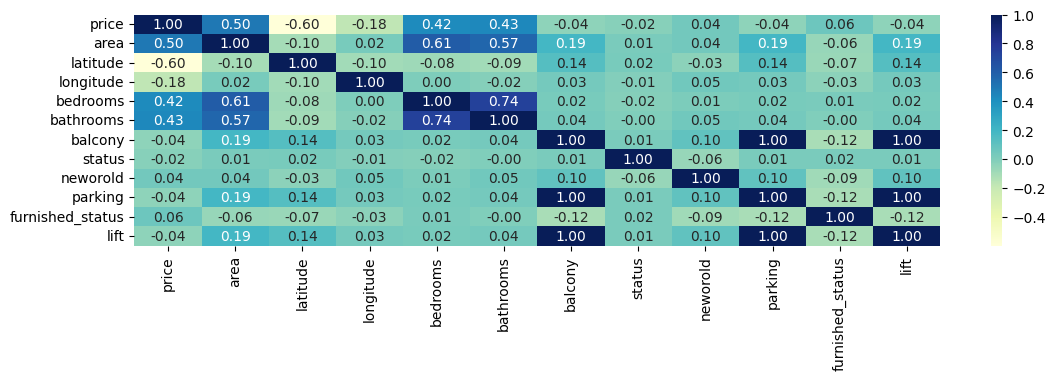

In [33]:
plt.figure(figsize=(13,3))
sns.heatmap(correlation_matrix, annot=True, cmap="YlGnBu", fmt=".2f")
plt.show

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6237 entries, 0 to 6236
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price             6237 non-null   float64
 1   area              6237 non-null   float64
 2   latitude          6237 non-null   float64
 3   longitude         6237 non-null   float64
 4   bedrooms          6237 non-null   int64  
 5   bathrooms         6237 non-null   int64  
 6   balcony           6237 non-null   int64  
 7   status            6237 non-null   bool   
 8   neworold          6237 non-null   bool   
 9   parking           6237 non-null   int64  
 10  furnished_status  6237 non-null   float64
 11  lift              6237 non-null   int64  
 12  type_of_building  6237 non-null   object 
dtypes: bool(2), float64(5), int64(5), object(1)
memory usage: 548.3+ KB


### Использование техники горячего кодирования

In [35]:
numeric_data = data_filtered.select_dtypes(exclude='object')
numeric_data

,price,area,latitude,longitude,bedrooms,bathrooms,balcony,status,neworold,parking,furnished_status,lift
0,22400000.0,629.0,19.032800,72.896357,2,2,0,False,True,0,0.0,0
1,35000000.0,974.0,19.032800,72.896357,3,2,0,False,True,0,0.0,0
2,31700000.0,968.0,19.085600,72.909277,3,3,0,False,True,0,0.0,0
3,18700000.0,629.0,19.155756,72.846862,2,2,2,True,True,2,0.0,2
4,13500000.0,1090.0,19.177555,72.849887,2,2,0,True,True,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6232,19500000.0,810.0,19.138320,72.810020,2,2,0,True,False,0,0.5,0
6233,22000000.0,1400.0,19.221920,72.854250,3,3,1,True,False,1,0.0,1
6234,20000000.0,750.0,19.144320,72.824111,2,2,0,True,False,0,0.0,0
6235,11000000.0,700.0,19.047201,72.872225,2,2,0,True,False,0,1.0,0


In [36]:
object_data = data_filtered.select_dtypes(include='object')
object_data

,type_of_building
0,Flat
1,Flat
2,Flat
3,Flat
4,Flat
...,...
6232,Flat
6233,Flat
6234,Flat
6235,Flat


In [37]:
data_objects_dummies = pd.get_dummies(object_data)

In [38]:
final_data = pd.concat([numeric_data,data_objects_dummies], axis=1)
final_data

,price,area,latitude,longitude,bedrooms,bathrooms,balcony,status,neworold,parking,furnished_status,lift,type_of_building_Flat,type_of_building_Individual House
0,22400000.0,629.0,19.032800,72.896357,2,2,0,False,True,0,0.0,0,1,0
1,35000000.0,974.0,19.032800,72.896357,3,2,0,False,True,0,0.0,0,1,0
2,31700000.0,968.0,19.085600,72.909277,3,3,0,False,True,0,0.0,0,1,0
3,18700000.0,629.0,19.155756,72.846862,2,2,2,True,True,2,0.0,2,1,0
4,13500000.0,1090.0,19.177555,72.849887,2,2,0,True,True,0,0.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6232,19500000.0,810.0,19.138320,72.810020,2,2,0,True,False,0,0.5,0,1,0
6233,22000000.0,1400.0,19.221920,72.854250,3,3,1,True,False,1,0.0,1,1,0
6234,20000000.0,750.0,19.144320,72.824111,2,2,0,True,False,0,0.0,0,1,0
6235,11000000.0,700.0,19.047201,72.872225,2,2,0,True,False,0,1.0,0,1,0


Таким образом, теперь мы сумеем использовать поле type_of_building в задачи регрессии

# Выделение целевого признака. Разбитие выборки.

Целевой признак был известен с самого начала - цена. Разобьем выборку на тестовую и обучающуюся.

In [39]:
y = final_data['price']
X = final_data.drop(['price'], axis=1)

In [40]:
y

0       22400000.0
1       35000000.0
2       31700000.0
3       18700000.0
4       13500000.0
           ...    
6232    19500000.0
6233    22000000.0
6234    20000000.0
6235    11000000.0
6236    15000000.0
Name: price, Length: 5524, dtype: float64

In [41]:
X

,area,latitude,longitude,bedrooms,bathrooms,balcony,status,neworold,parking,furnished_status,lift,type_of_building_Flat,type_of_building_Individual House
0,629.0,19.032800,72.896357,2,2,0,False,True,0,0.0,0,1,0
1,974.0,19.032800,72.896357,3,2,0,False,True,0,0.0,0,1,0
2,968.0,19.085600,72.909277,3,3,0,False,True,0,0.0,0,1,0
3,629.0,19.155756,72.846862,2,2,2,True,True,2,0.0,2,1,0
4,1090.0,19.177555,72.849887,2,2,0,True,True,0,0.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6232,810.0,19.138320,72.810020,2,2,0,True,False,0,0.5,0,1,0
6233,1400.0,19.221920,72.854250,3,3,1,True,False,1,0.0,1,1,0
6234,750.0,19.144320,72.824111,2,2,0,True,False,0,0.0,0,1,0
6235,700.0,19.047201,72.872225,2,2,0,True,False,0,1.0,0,1,0


In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 


<font color=darkviolet size=5>
Simple Linear Regression

In [43]:
pipeline = Pipeline(
    [
        # ('minmaxscaler', MinMaxScaler()),
        ('stdscaler', StandardScaler()),
        ('model', LinearRegression()),
    ]
)

x_simple_train = X_train['area'].values.reshape(-1,1)
x_simple_test = X_test['area'].values.reshape(-1,1)


In [44]:
import numpy as np


*Без регуляризации*

In [45]:
lr = pipeline.fit(x_simple_train, y_train)


<AxesSubplot: ylabel='price'>

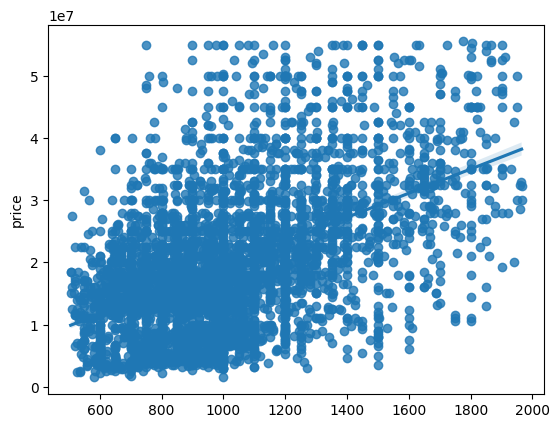

In [46]:
sns.regplot(x = x_simple_train, y = y_train)

In [47]:
# получаем предсказания для тестовой выборки
y_pred = lr.predict(x_simple_test)

In [48]:
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test, y_pred))}')
print(f'MAPE: {sqrt(mean_absolute_percentage_error(y_test, y_pred))}')
print(f'R^2: {lr.score(x_simple_test, y_test)}')

MAE: 7242611.819834112
MSE: 90373732031377.03
RMSE: 9506509.981658729
MAPE: 0.7789554292896218
R^2: 0.2249882617454918


*С регуляризацией*

In [49]:
pipeline = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        ("model", Lasso()),
    ]
)

param_grid = {
    "model__alpha": np.arange(0.1, 1, 0.1)
}

gridsearch = GridSearchCV(pipeline, param_grid, scoring="r2")
gridsearch.fit(x_simple_train, y_train)
best_params = gridsearch.best_params_
best_params["model__alpha"]


0.9

Я так понимаю, что не важно, скейлим мы наши данные или нет, результат тот же? Неправильно понимаешь, результат не тот же, частный случай не о многом говорит

In [50]:
ridge_optimal = GridSearchCV(Ridge(), {'alpha': np.arange(0, 1, 0.1)} ).fit(x_simple_train, y_train)
# выводим оптимальные значения параметров
ridge_optimal.best_params_

{'alpha': 0.9}

In [51]:
# L1
ridge = Ridge(alpha= best_params["model__alpha"]).fit(x_simple_train, y_train)
y_pred = ridge.predict(x_simple_test)
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test, y_pred))}')
print(f'MAPE: {sqrt(mean_absolute_percentage_error(y_test, y_pred))}')
print(f'R^2: {ridge.score(x_simple_test, y_test)}')
print()
print(f'коэфф: {ridge.coef_}')
print(f'пересеч: {ridge.intercept_}')

MAE: 7242611.819075822
MSE: 90373732022376.31
RMSE: 9506509.98118533
MAPE: 0.7789554293630417
R^2: 0.22498826182267861

коэфф: [19391.75218403]
пересеч: 86504.31566999853


In [52]:
# L2
lasso = Lasso(alpha= best_params["model__alpha"]).fit(x_simple_train, y_train)

y_pred = lasso.predict(x_simple_test)

print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test, y_pred))}')
print(f'MAPE: {sqrt(mean_absolute_percentage_error(y_test, y_pred))}')
print(f'R^2: {ridge.score(x_simple_test, y_test)}')
print(f'коэфф: {ridge.coef_}')
print(f'пересеч: {ridge.intercept_}')

MAE: 7242611.819661312
MSE: 90373732029325.92
RMSE: 9506509.981550848
MAPE: 0.7789554293063528
R^2: 0.22498826182267861
коэфф: [19391.75218403]
пересеч: 86504.31566999853


<b><font color=green size = 5>**Множественная линейная регрессия**

(При каждом новом способе решения задачи линейной регресси же нужно заново разбивать выборку на тестовую и обучающуюся как ниже же? Хоть у нас X_train будет другой y_train будет после линейной простой регрессии, т.е. не в начальной форме, то есть уже "подогнанный"? 

Ибо я заметил, что не обнуляя данные r2 имеет чуть больший результат)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
pipeline = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        ("model", LinearRegression()),
    ]
)

pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('model', LinearRegression())])

In [54]:
pipeline.named_steps["model"].coef_

array([ 1.81496825e+07, -3.35165152e+07, -1.93828686e+07,  1.09631188e+07,
        1.65816046e+07, -1.49376519e+19, -4.92142586e+06,  3.74541593e+05,
        3.10509763e+19,  7.82141021e+05, -1.61133244e+19, -8.31078480e+16,
       -8.31078480e+16])

In [55]:
y_pred = pipeline.predict(X_test)

print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test, y_pred))}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, y_pred)}')
print(f'R^2: {pipeline.score(X_test, y_test)}')

MAE: 4771622.573755656
MSE: 45011241073316.49
RMSE: 6709041.740317055
MAPE: 0.30874728317413314
R^2: 0.6256417355696242


/tmp/ipykernel_3280/1760691979.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 =  sns.distplot(y_test, hist=False, color='Red', label='Actual price')
/tmp/ipykernel_3280/1760691979.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, hist=False, color='Blue', ax=ax1, label='P

<AxesSubplot: xlabel='price', ylabel='Density'>

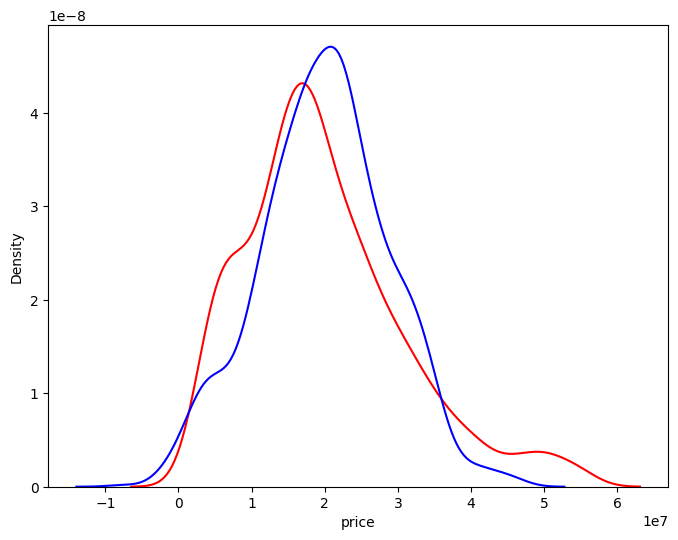

In [56]:

plt.figure(figsize=(8,6))

ax1 =  sns.distplot(y_test, hist=False, color='Red', label='Actual price')
sns.distplot(y_pred, hist=False, color='Blue', ax=ax1, label='Predicted price')

Очень неплохая аппроксимация вышла

(результат со старой y_train)

In [57]:
y_pred = pipeline.predict(X_test)

print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test, y_pred))}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, y_pred)}')
print(f'R^2: {pipeline.score(X_test, y_test)}')

MAE: 4771622.573755656
MSE: 45011241073316.49
RMSE: 6709041.740317055
MAPE: 0.30874728317413314
R^2: 0.6256417355696242


**Ridge**

In [58]:
pipeline = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        ("model", Ridge()),
    ]
)

param_grid = {
    "model__alpha": np.arange(0.1, 1, 0.1)
}

gridsearch = GridSearchCV(pipeline, param_grid, scoring="r2")
gridsearch.fit(X_train, y_train)
best_params = gridsearch.best_params_
best_params

{'model__alpha': 0.30000000000000004}

In [59]:
# L1
pipeline.set_params(**best_params).fit(X_train, y_train)
y_pred = ridge.predict(x_simple_test)
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test, y_pred))}')
print(f'MAPE: {sqrt(mean_absolute_percentage_error(y_test, y_pred))}')
print(f'R^2: {ridge.score(x_simple_test, y_test)}')
print()
print(f'коэфф: {ridge.coef_}')
print(f'пересеч: {ridge.intercept_}')

MAE: 9747555.918016894
MSE: 157607468771905.22
RMSE: 12554181.32623172
MAPE: 0.8874526844709892
R^2: -0.31082052091410484

коэфф: [19391.75218403]
пересеч: 86504.31566999853


**Lasso**

In [60]:
pipeline = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        ("model", Lasso()),
    ]
)

param_grid = {
    "model__alpha": np.arange(0.1, 1, 0.1)
}

gridsearch = GridSearchCV(pipeline, param_grid, scoring="r2")
gridsearch.fit(X_train, y_train)
best_params = gridsearch.best_params_
best_params

/home/timofey/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.996e+15, tolerance: 4.337e+13
  model = cd_fast.enet_coordinate_descent(
/home/timofey/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.623e+15, tolerance: 4.299e+13
  model = cd_fast.enet_coordinate_descent(
/home/timofey/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/home/timofey/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.996e+15, tolerance: 4.337e+13
  model = cd_fast.enet_coordinate_descent(
/home/timofey/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.623e+15, tolerance: 4.299e+13
  model = cd_fast.enet_coordinate_descent(
/home/timofey/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

{'model__alpha': 0.1}

In [61]:
# L2
pipeline.set_params(**best_params).fit(X_train, y_train)
y_pred = lasso.predict(x_simple_test)

print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test, y_pred))}')
print(f'MAPE: {sqrt(mean_absolute_percentage_error(y_test, y_pred))}')
print(f'R^2: {ridge.score(x_simple_test, y_test)}')
print()
print(f'коэфф: {ridge.coef_}')
print(f'пересеч: {ridge.intercept_}')

MAE: 9747555.9220963
MSE: 157607468898137.62
RMSE: 12554181.331259225
MAPE: 0.887452684592648
R^2: -0.31082052091410484

коэфф: [19391.75218403]
пересеч: 86504.31566999853


/home/timofey/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.567e+15, tolerance: 5.430e+13
  model = cd_fast.enet_coordinate_descent(


Видим, что регуляризации в обоих случаях ухудшила ситуацию

 *Попробуем с **ElasticNet()***

In [62]:
pipeline = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        ("model", ElasticNet()),
    ]
)

param_grid = {
    "model__alpha": np.arange(0.1, 1, 0.1)
}

gridsearch = GridSearchCV(pipeline, param_grid, scoring="r2")
gridsearch.fit(X_train, y_train)
best_params = gridsearch.best_params_
best_params

{'model__alpha': 0.1}

In [63]:
# ElasticNet
pipeline.set_params(**best_params).fit(X_train, y_train)
y_pred = ridge.predict(x_simple_test)

print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test, y_pred))}')
print(f'MAPE: {sqrt(mean_absolute_percentage_error(y_test, y_pred))}')
print(f'R^2: {ridge.score(x_simple_test, y_test)}')
print()
print(f'коэфф: {ridge.coef_}')
print(f'пересеч: {ridge.intercept_}')

MAE: 9747555.918016894
MSE: 157607468771905.22
RMSE: 12554181.32623172
MAPE: 0.8874526844709892
R^2: -0.31082052091410484

коэфф: [19391.75218403]
пересеч: 86504.31566999853


ElasticNet() тоже разочаровал

<b><font color= brown size = 5>**Полиномиальная линейная регрессия**

(заметил прикол местный, если много раз кликать на разбиение выборки и после смотреть r2 оценку, то можно нарандомить на наилучший результат, это можно объяснить работой параметра shuffle, так?)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [2]:
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("polynomial", PolynomialFeatures(2)),
        ("model", LinearRegression()),
        
    ]
)

In [77]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test, y_pred))}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, y_pred)}')
print(f'R^2: {pipeline.score(X_test, y_test)}')



MAE: 4823080.09321267
MSE: 46132311236868.33
RMSE: 6792077.092971511
MAPE: 0.3390438347868102
R^2: 0.6426944204522489


Среди испытанных степеней полинома 2, 3, 4 и 5 2-ая степень показала наилучший результат. Проиллюстирируем нашу аппроксимацию:

/tmp/ipykernel_3280/290870963.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax2 = sns.distplot(y_test, hist=False, color='Red', label='Actual values')
/tmp/ipykernel_3280/290870963.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, hist=False, color='Green', label='Predicted 

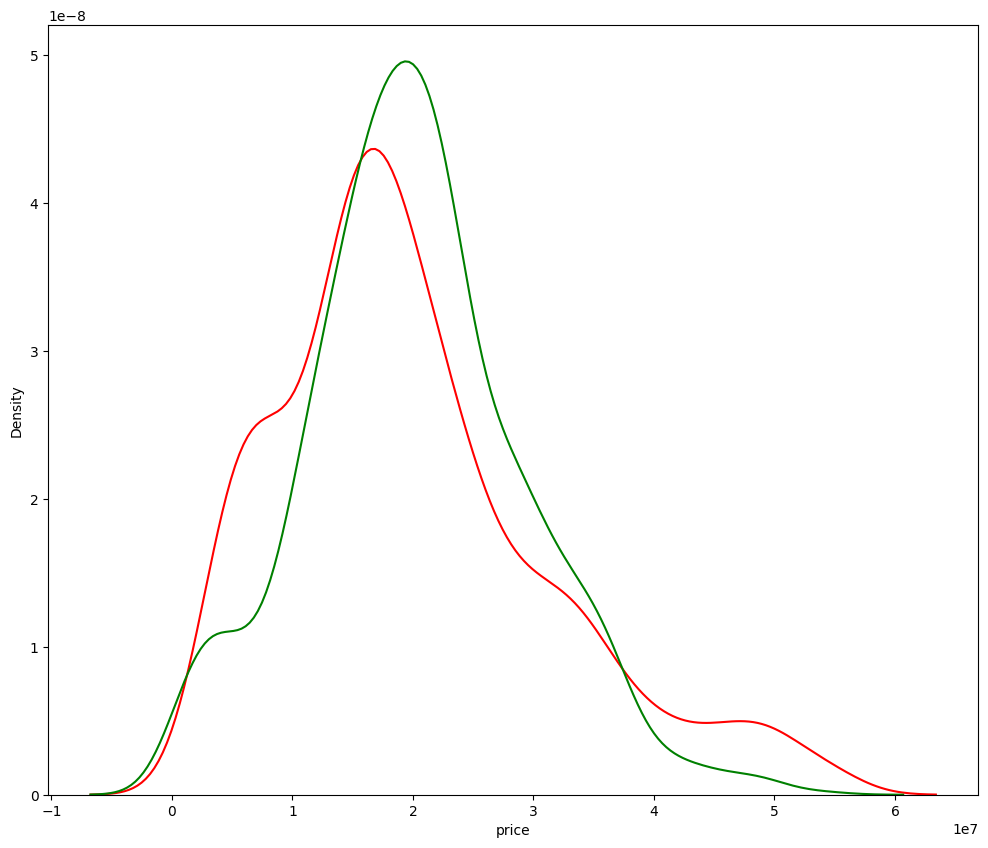

In [67]:
plt.figure(figsize=(12,10))
ax2 = sns.distplot(y_test, hist=False, color='Red', label='Actual values')
sns.distplot(y_pred, hist=False, color='Green', label='Predicted values')
plt.show()

Pipeline with preprocessed data

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
regression_data = pd.read_csv("../data/regression_preprocessed_data")

y = regression_data['price']
X = regression_data.drop(['price'], axis=1)
# X = regression_data.drop(columns=['price'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= .3)

In [4]:
X

,area,latitude,longitude,bedrooms,bathrooms,balcony,parking,furnished_status,lift,type_of_building_Flat,type_of_building_Individual House,status_False,status_True,neworold_False,neworold_True
0,629.0,19.032800,72.896357,2,2,0,0,0.0,0,1,0,1,0,0,1
1,974.0,19.032800,72.896357,3,2,0,0,0.0,0,1,0,1,0,0,1
2,968.0,19.085600,72.909277,3,3,0,0,0.0,0,1,0,1,0,0,1
3,629.0,19.155756,72.846862,2,2,2,2,0.0,2,1,0,0,1,0,1
4,1090.0,19.177555,72.849887,2,2,0,0,0.0,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6232,810.0,19.138320,72.810020,2,2,0,0,0.5,0,1,0,0,1,1,0
6233,1400.0,19.221920,72.854250,3,3,1,1,0.0,1,1,0,0,1,1,0
6234,750.0,19.144320,72.824111,2,2,0,0,0.0,0,1,0,0,1,1,0
6235,700.0,19.047201,72.872225,2,2,0,0,1.0,0,1,0,0,1,1,0


In [21]:
from sklearn.kernel_ridge import KernelRidge

In [51]:
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("polynomial", PolynomialFeatures(2)),
        ("model", KernelRidge()),
        
    ]
)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
r2_score(y_test, y_pred)

0.7440312049218504

/tmp/ipykernel_14593/290870963.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax2 = sns.distplot(y_test, hist=False, color='Red', label='Actual values')
/tmp/ipykernel_14593/290870963.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, hist=False, color='Green', label='Predicte

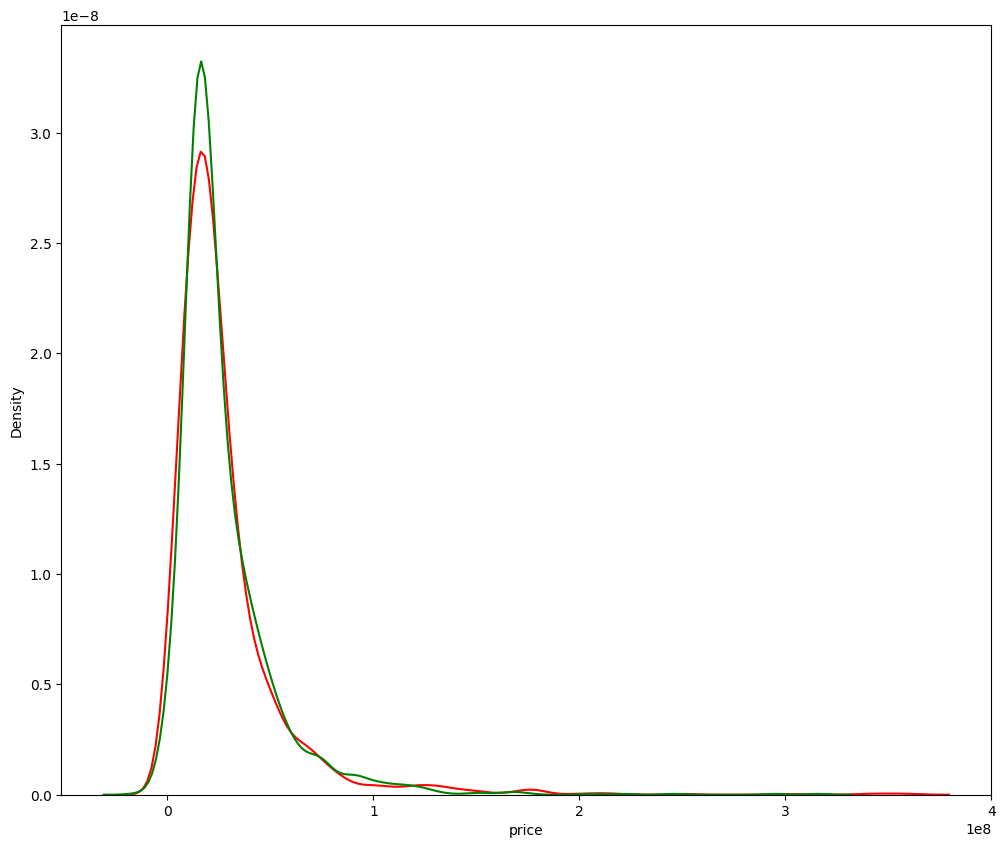

In [52]:
plt.figure(figsize=(12,10))
ax2 = sns.distplot(y_test, hist=False, color='Red', label='Actual values')
sns.distplot(y_pred, hist=False, color='Green', label='Predicted values')
plt.show()


In [46]:
import joblib

In [47]:
joblib.dump(pipeline, "../models/MODEL_ONE_polynomial_best_regression_model.pkl")

['../models/MODEL_ONE_polynomial_best_regression_model.pkl']

In [48]:
test_model = joblib.load('../models/MODEL_ONE_polynomial_best_regression_model.pkl')

In [50]:
r2_score(test_model.predict(X_test), y_test)

0.64236554881302

In [42]:
dict(pipeline.steps)['polynomial']

PolynomialFeatures(degree=3)

In [44]:
param_grid = {
    "steps": [PolynomialFeatures(1), PolynomialFeatures(2), PolynomialFeatures(3),
                   PolynomialFeatures(4), PolynomialFeatures(5), PolynomialFeatures(6)],
    # 'steps["model"]': [KernelRidge(), LinearRegression()]
}

gridsearch = GridSearchCV(estimator= Pipeline(
    [
        ("scaler", StandardScaler()),
        # ("polynomial", PolynomialFeatures(3)),
        ("model", KernelRidge()),
        
    ]
), param_grid=param_grid, n_jobs= -1, verbose=0, scoring="r2")
gridsearch.fit(X_train, y_train)

TypeError: 'PolynomialFeatures' object is not subscriptable

dumping and loading the model to check

In [ ]:
import joblib
joblib.dump(gridsearch.best_estimator_, '../models/MODEL_ONE_polynomial_best_regression_model.pkl')


['../models/MODEL_ONE_polynomial_best_regression_model.pkl']

In [ ]:
loaded_model = joblib.load('../models/MODEL_ONE_polynomial_best_regression_model.pkl')

In [ ]:
loaded_model.score(X_test, y_test)

0.6426928894423174

**Ridge**

In [68]:
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("polynomial", PolynomialFeatures(2)),
        ("model", Ridge()),
        
    ]
)

param_grid = {
    "model__alpha": np.arange(0.1, 1, 0.1)
}

gridsearch = GridSearchCV(pipeline, param_grid, scoring="r2")
gridsearch.fit(X_train, y_train)
best_params = gridsearch.best_params_

pipeline.set_params(**best_params).fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test, y_pred))}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, y_pred)}')
print(f'R^2: {pipeline.score(X_test, y_test)}')


MAE: 4823106.954234442
MSE: 46133492891860.875
RMSE: 6792164.080163322
MAPE: 0.33905353145656414
R^2: 0.6426852682569519


**Lasso**

In [93]:
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("polynomial", PolynomialFeatures(2)),
        ("model", Lasso()),
        
    ]
)

param_grid = {
    "model__alpha": np.arange(0.1, 1, 0.1)
}

gridsearch = GridSearchCV(pipeline, param_grid, scoring="r2")
gridsearch.fit(X_train, y_train)
best_params = gridsearch.best_params_


pipeline.set_params(**best_params).fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test, y_pred))}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, y_pred)}')
print(f'R^2: {pipeline.score(X_test, y_test)}')

/home/timofey/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.921e+16, tolerance: 4.311e+13
  model = cd_fast.enet_coordinate_descent(
/home/timofey/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.998e+16, tolerance: 4.252e+13
  model = cd_fast.enet_coordinate_descent(
/home/timofey/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

MAE: 4823105.830052181
MSE: 46132508908079.49
RMSE: 6792091.644558361
MAPE: 0.33905182160407565
R^2: 0.6426928894423174


/home/timofey/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.726e+16, tolerance: 5.332e+13
  model = cd_fast.enet_coordinate_descent(


In [94]:

print(f'R^2: {gridsearch.score(X_test, y_test)}')

R^2: 0.6426928894423174


In [96]:
y_pred = gridsearch.predict(X_test)

print(r2_score(y_test, y_pred))

0.6426928894423174


Ух ты! Единственный раз в полиномиальной регресси регулизация Лассо показала положительный результат: на 10-тысячную доль результат улучшился в то время, как Ридж показал чуть хуже результат

In [ ]:
pipeline.best_params

## Релизация метрик

In [70]:
def MAE(y_test, y_pred):
  return  abs(y_test-y_pred).mean()

print(f'MAE: {mean_absolute_error(y_test, y_pred)}, My MAE: {MAE(y_test, y_pred)}, проверим равенство: {MAE(y_test, y_pred) == mean_absolute_error(y_test, y_pred)}')

MAE: 4823105.830052181, My MAE: 4823105.830052181, проверим равенство: True


In [71]:
def MSE(y_test, y_pred):
  return  ((y_test-y_pred)**2).mean()

print(f'MAE: {mean_squared_error(y_test, y_pred)}, My MAE: {MSE(y_test, y_pred)}, проверим равенство: {MSE(y_test, y_pred) == mean_squared_error(y_test, y_pred)}')

MAE: 46132508908079.49, My MAE: 46132508908079.49, проверим равенство: True


In [72]:
def RMSE(y_test, y_pred):
  return  sqrt(MSE(y_test, y_pred))

print(f'RMSE: {sqrt(mean_squared_error(y_test, y_pred))}, My RMSE: {RMSE(y_test, y_pred)}, проверим равенство: {sqrt(mean_squared_error(y_test, y_pred)) == RMSE(y_test, y_pred)}')

RMSE: 6792091.644558361, My RMSE: 6792091.644558361, проверим равенство: True


In [73]:
def MAPE(y_test, y_pred):
  return  abs((y_test-y_pred) / y_test).mean()

print(f'MAPE: {mean_absolute_percentage_error(y_test, y_pred)}, My_MAPE: {MAPE(y_test,y_pred)}, проверим равенство: {MAPE(y_test,y_pred) == mean_absolute_percentage_error(y_test, y_pred)}')

MAPE: 0.33905182160407565, My_MAPE: 0.33905182160407565, проверим равенство: True


In [74]:
def R2(y_test, y_pred):
  return  1 - MSE(y_test, y_pred)/ ((y_test- y_test.mean())**2).mean()
print(f'R^2: {pipeline.score(X_test, y_test)}, My R2: {R2(y_test, y_pred)}, проверим равенство: {round(pipeline.score(X_test, y_test), 3) == round(R2(y_test, y_pred), 3)}')

R^2: 0.6426928894423174, My R2: 0.6426928894423174, проверим равенство: True
